In [1]:
import numpy
import math

import random
import time
import matplotlib.pyplot as plt

In [2]:
environment = numpy.zeros((5, 5))
trans_prob = 1
environment[4, 4] = 10
#environment[2, 3] = -5

In [3]:
alpha = 0.5
gamma = 0.9

In [4]:
def get_legal_actions(pos):
    legal_actions = list()
    new_pos = list()
    all_actions = [[1, 0], [0, 1], [-1, 0], [0, -1]]
    for i in all_actions:
        try:
            new_pos = numpy.add(pos, numpy.array(i))
            legal_actions.append(i)
            env = environment[new_pos[0]][new_pos[1]]
            if any(j < 0 for j in new_pos):
                legal_actions.pop()
        except IndexError:
            legal_actions.pop()
            
        
    return legal_actions

In [5]:
def take_action(pos, action):
    # Take action in the actual environment and return a reward and new position based on environment dynamics
    if numpy.random.rand(1) < 0:
        new_pos = numpy.add(pos, action)
    else:
        new_pos = numpy.add(pos, random.choice(get_legal_actions(pos)))
    reward = environment[new_pos[0]][new_pos[1]]
    return new_pos, reward

In [6]:
mb_internal_environment = numpy.zeros((5, 5))


In [7]:
def mb_internal_environment_value(pos):
    value = mb_internal_environment[pos[0], pos[1]]
    return value

In [8]:
def update_mb_internal_environment(pos, next_pos, reward):
    next_value_list = list()
    for i in get_legal_actions(next_pos):
        next_value_list.append(mb_internal_environment[next_pos[0]][next_pos[1]])
    next_value = max(next_value_list)
    mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos) + (alpha) * (reward + gamma*next_value)
    


In [9]:
def dls(pos, curr_depth, max_depth):
    value_list = list()
    if curr_depth == max_depth:
        return mb_internal_environment_value(pos)
    else:
        actions = get_legal_actions(pos)
        for i in actions:
            next_pos = numpy.add(numpy.array(pos), numpy.array(i))
            value = mb_internal_environment_value(pos) + gamma * dls(next_pos, curr_depth+1, max_depth)
            value_list.append(value)
        if value_list:
            average_value = numpy.mean(numpy.array(value_list))
    return average_value

In [10]:
def dls_action(pos, max_depth):
    # Do depth Limited Search till max_depth on the mb_internal_environment
    actions = get_legal_actions(pos)
    next_value_list = list()
    next_pos_list = list()
    for i in actions:
        next_pos = numpy.add(numpy.array(pos), numpy.array(i))
        next_value_list.append(dls(next_pos, 0, max_depth))
        next_pos_list.append(next_pos)
    action = actions[numpy.argmax(next_value_list)]
    return action

In [11]:
def q_action(pos):
    # Look for q values in mf_internal_environment for given position
    actions = get_legal_actions(pos)
    next_value_list = list()
    next_pos_list = list()
    for i in actions:
        next_pos = numpy.add(numpy.array(pos), numpy.array(i))
        next_value_list.append(mb_internal_environment[next_pos[0], next_pos[1]])
        next_pos_list.append(next_pos)
    action = actions[numpy.argmax(next_value_list)]
    return action

In [12]:
def dual(num_iters):
    sum_reward = 0
    max_depth = 4
    steps_per_reward = 0
    steps = list()
    for i in range(num_iters):
        pos = [0, 0]
        while True:
            if j%(i+1) == 0:
                action = dls_action(pos, max_depth)
                next_pos, reward = take_action(pos, action)
                update_mb_internal_environment(pos, next_pos, reward)
                pos = next_pos
            else:
                action = q_action(pos)
                next_pos, reward = take_action(pos, action)
                update_mb_internal_environment(pos, next_pos, reward)
                pos = next_pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            if reward != 0:
                steps.append(steps_per_reward)
                steps_per_reward = 0
                break
    return sum_reward, steps

In [13]:
def mb(num_iters):
    sum_reward = 0
    max_depth = 4
    steps = list()
    for i in range(num_iters):
        pos = [0, 0]
        steps_per_reward = 0
        while True:
            action = dls_action(pos, max_depth)
            next_pos, reward = take_action(pos, action)
            update_mb_internal_environment(pos, next_pos, reward)
            pos = next_pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            if reward != 0:
                
                steps.append(steps_per_reward)
                steps_per_reward = 0
                break

    return sum_reward, steps

In [14]:
def mf(num_iters):
    sum_reward = 0
    max_depth = 4
    steps = list()
    for i in range(num_iters):
        pos = [0, 0]
        steps_per_reward = 0        
        print (mb_internal_environment)
        
        while True:
            action = q_action(pos)
            next_pos, reward = take_action(pos, action)
            update_mb_internal_environment(pos, next_pos, reward)
            pos = next_pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            if reward != 0:
                mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos) + (alpha) * (reward)
                steps.append(steps_per_reward)
                steps_per_reward = 0
                break
            
    return sum_reward, steps

In [15]:
mb_internal_environment = numpy.zeros((5, 5))


Run the Dual Process on grid world. Get a list of individual time taken for each and rewards obtained.

In [29]:
times_dual = list()
reward_dual = list()
steps_dual = list()
for i in range(10):
    mb_internal_environment = numpy.zeros((5, 5))
    start_time = time.time()
    dual_result = mb(15)
    reward_dual.append(dual_result[0])
    steps_dual.append(dual_result[1])
    times_dual.append(time.time() - start_time)


In [16]:
times_mb = list()
reward_mb = list()
steps_mb = list()
for i in range(10):
    mb_internal_environment = numpy.zeros((5, 5))
    start_time = time.time()
    mb_result = mb(15)
    reward_mb.append(mb_result[0])
    steps_mb.append(mb_result[1])
    times_mb.append(time.time() - start_time)


In [17]:
times_mf = list()
reward_mf = list()
steps_mf = list()
for i in range(10):
    mb_internal_environment = numpy.zeros((5, 5))
    start_time = time.time()
    mf_result = mf(15)
    reward_mf.append(mf_result[0])
    steps_mf.append(mf_result[1])
    times_mf.append(time.time() - start_time)


[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  5.]
 [ 0.  0.  0.  0.  5.]]
[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    5.  ]
 [ 0.    0.    0.    7.25  7.5 ]]
[[  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.39721957   0.           0.        ]
 [  0.           0.           0.18113222   2.29190625   5.        ]
 [  0.           0.           1.68926388  10.1875       8.75      ]]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   3.75791520e-02
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   4.46872017e-02   1.13809512e-01
    1.04728439e-01]
 [  0.00000000e+00   1.07714040e-01   1.79741856e-01   8.45756733e-01
    6.61130

In [42]:
print (steps_mf[2])


[82, 16, 158, 40, 40, 126, 48, 72, 10, 18, 112, 24, 98, 22, 34]


[ 29.2  52.4  38.6  55.6  37.   67.   33.4  40.   47.8  37.8  59.2  32.8
  38.2  53.4  75.4]
[ 38.2  44.   26.2  30.4  32.4  45.2  31.6  46.   33.   38.2  31.4  53.4
  35.4  35.2  29.6]
[ 31.   47.6  55.6  33.6  42.   54.   40.6  38.4  35.4  35.6  47.   45.
  43.8  34.2  45.8]


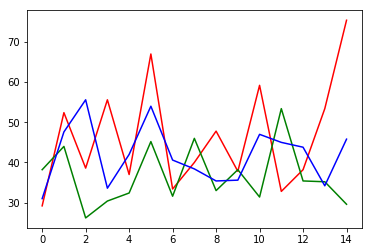

In [20]:
#print (sum(steps_mf)/300)
#print (sum(steps_mb)/300)
#print (sum(steps_dual)/300)
print (numpy.mean(numpy.array(steps_mf), axis=0))
print (numpy.mean(numpy.array(steps_dual), axis=0))
print (numpy.mean(numpy.array(steps_mb), axis=0))

stepsmf_plot, = plt.plot(numpy.arange(0, 15), numpy.mean(numpy.array(steps_mf), axis=0), color = 'r')
stepsdual_plot, = plt.plot(numpy.arange(0, 15), numpy.mean(numpy.array(steps_dual), axis=0), color = 'g')
stepsmb_plot, = plt.plot(numpy.arange(0, 15), numpy.mean(numpy.array(steps_mb), axis=0), color = 'b')

#plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.show()

In [44]:
reward_mean_dual = numpy.mean(numpy.array(reward_dual))
reward_mean_mb = numpy.mean(numpy.array(reward_mb))
reward_mean_mf = numpy.mean(numpy.array(reward_mf))
times_mean_dual = numpy.mean(numpy.array(times_dual))
times_mean_mb = numpy.mean(numpy.array(times_mb))
times_mean_mf = numpy.mean(numpy.array(times_mf))
steps_mean_dual = sum(steps_dual)/400
steps_mean_mb = sum(steps_mb)/400
steps_mean_mf = sum(steps_mf)/400


In [45]:
reward_errors = ([max(reward_dual) - numpy.mean(numpy.array(reward_dual)), max(reward_mb) - numpy.mean(numpy.array(reward_mb)), max(reward_mf) - numpy.mean(numpy.array(reward_mf))]), 

In [46]:
times_errors = ([max(times_dual) - numpy.mean(numpy.array(times_dual)), max(times_mb) - numpy.mean(numpy.array(times_mb)), max(times_mf) - numpy.mean(numpy.array(times_mf))]), 

In [47]:
times_errors = ([max(times_dual) - numpy.mean(numpy.array(times_dual)), max(times_mb) - numpy.mean(numpy.array(times_mb)), max(times_mf) - numpy.mean(numpy.array(steps_mf))]), 

In [48]:
rewards = numpy.array([reward_mean_mb, reward_mean_dual, reward_mean_mf])
#yerror = numpy.array(reward_errors)
print (rewards)

[ 5.00593811  5.0029708   5.00012459]


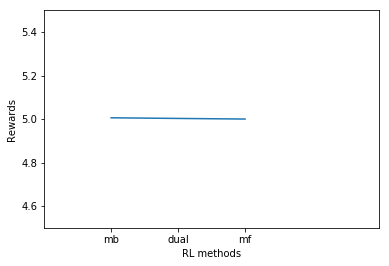

In [49]:
reward_plot, = plt.plot(numpy.arange(0, 3), rewards)
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 4)
plt.ylim(ymin = 4.5, ymax = 5.5)
plt.xlabel('RL methods')
plt.ylabel("Rewards")

plt.show()

[ 7.38872306  7.37350442  0.07987127]


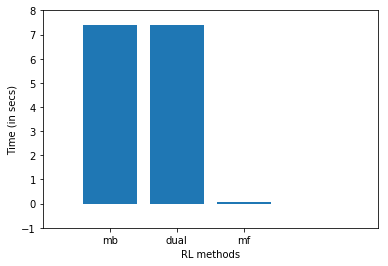

In [51]:
times = numpy.array([times_mean_mb, times_mean_dual, times_mean_mf])
print (times)
plt.bar(numpy.arange(3), times, align='center')
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 4)
plt.ylim(ymin = -1, ymax = 8)
plt.xlabel('RL methods')
plt.ylabel("Time (in secs)")

plt.show()

[ 48.325  45.015  55.955]


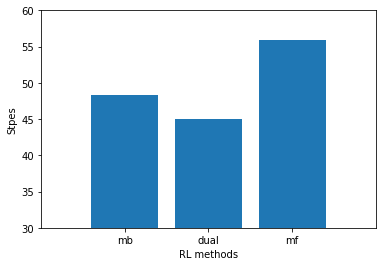

In [52]:
steps = numpy.array([steps_mean_mb, steps_mean_dual, steps_mean_mf])
print (steps)
plt.bar(numpy.arange(3), steps, align='center')
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 3)
plt.ylim(ymin = 30, ymax = 60)
plt.xlabel('RL methods')
plt.ylabel("Stpes")

plt.show()